__Author:__ Bram Van de Sande

__Date:__ 8 FEB 2018

__Outline:__ Compare the results of the different implementation of the SCENIC pipeline. The example used in the tutorial is used in this comparison (https://github.com/aertslab/SCENIC). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Phase Ib: Derive potential regulomes from these co-expression modules

#### Check implementation of `modules_from_genie3`

Start from the GENIE3 output and check if derived co-expression modules are similar.

In [2]:
adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.5_GENIE3_linkList.txt',
                          usecols=['TF', 'Target', 'weight'])
adjacencies.columns = ["TF", "target", "importance"]

Creation of the modules.

In [5]:
df_modules = adjacencies[adjacencies['importance'] > 0.001]
df_modules['method'] = 'w001'

df_tmp = adjacencies[adjacencies['importance'] > 0.005].copy()
df_tmp['method'] = 'w005'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='TF').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(5, "importance")).copy()
df_tmp['method'] = 'top5perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(10, "importance")).copy()
df_tmp['method'] = 'top10perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50perTarget'
df_modules = df_modules.append(df_tmp)
df_modules.index = range(len(df_modules))

In [6]:
len(df_modules)

4363616

In [7]:
df_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

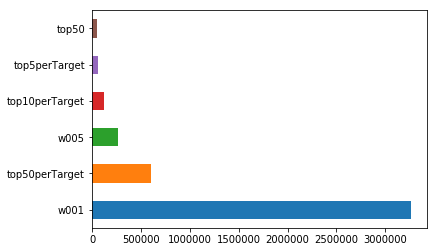

In [8]:
df_modules.method.value_counts().plot.barh()

In [9]:
df_modules[df_modules['TF'] == df_modules['target']]

,TF,target,importance,method


Compare the results with the modules derived by the R pipeline.

In [10]:
r_modules = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.6_tfModules.txt',
                          usecols=['Target', 'TF', 'method'])
r_modules.columns = ['target', 'TF', 'method']

In [12]:
len(r_modules)

4363616

In [13]:
r_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

Exact comparison.

In [14]:
COLUMN_NAMES = ['TF', 'target', 'method']
df_modules = df_modules[COLUMN_NAMES].sort_values(by=COLUMN_NAMES).reset_index()
del df_modules['index']

In [15]:
r_modules = r_modules.sort_values(by=COLUMN_NAMES).reset_index()
del r_modules['index']
r_modules = r_modules[COLUMN_NAMES]

In [16]:
r_modules.equals(df_modules)

True

### Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)

Testing of RcisTarget should start from exactly the same baseline. Modules for the python pipeline will therefore be created from the link lists with correlation information used in the R scripts.

In [43]:
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
import os
from collections import defaultdict
from pyscenic.genesig import Regulome
from operator import concat
from functools import reduce
from pyscenic.regulome import derive_regulomes

In [44]:
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"
DATABASE_FNAME_500bp = os.path.join(DATABASE_FOLDER, "mm9-500bp-upstream-10species.mc9nr.feather")
DATABASE_FNAME_10kbp = os.path.join(DATABASE_FOLDER, "mm9-tss-centered-10kb-10species.mc9nr.feather")

RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")

#### Create modules from R datafile

In [45]:
r_adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.7_tfModules_withCorr.txt',
                         usecols=['Target', 'TF', 'method', 'corr'])
r_adjacencies.head()

,Target,TF,method,corr
0,Slc27a3,1810024B03Rik,w001,0
1,Ankrd39,1810024B03Rik,w001,1
2,Tbc1d25,1810024B03Rik,w001,0
3,Mak,1810024B03Rik,w001,1
4,Tmem86b,1810024B03Rik,w001,1


1. Remove genes in a module that are not part of the database rankings.
2. Remove modules with number of genes < 20.
3. Add own TF to its own module.
4. Only look at TF-target that have an activiting function.

In [46]:
genes_in_db = RankingDatabase(DATABASE_FNAME_500bp, name="500bp", nomenclature="MGI").geneset
r_adjacencies = r_adjacencies[r_adjacencies['corr'] > 0]
method2modules = defaultdict(list)
for (tf, method), df_grp in r_adjacencies.groupby(by=['TF', 'method']):
    targets = set(df_grp['Target'].values)
    if len(targets) < 20:
        continue
    targets.add(tf)
    regulome = Regulome(name="{} - {}".format(tf, method), nomenclature="MGI", 
                        score=0.0, context=frozenset([method]),
                        transcription_factor=tf, gene2weights=targets.intersection(geneset))
    method2modules[method].append(regulome)

In [47]:
for method, modules in method2modules.items():
    print(method, "-", len(modules))

top50 - 974
top50perTarget - 976
w001 - 1004
w005 - 612
top10perTarget - 486
top5perTarget - 259


In [48]:
modules = reduce(concat, method2modules.values())
len(modules)

4311

#### Create dataframe with enriched and annotated motifs

In [49]:
rnkdbs = [RankingDatabase(fname, name, "MGI") for fname, name in zip([DATABASE_FNAME_500bp, DATABASE_FNAME_10kbp], ['500bp', '10kbp'])]
rnkdbs

[FeatherRankingDatabase(name="500bp",nomenclature=MGI),
 FeatherRankingDatabase(name="10kbp",nomenclature=MGI)]

In [ ]:
df = derive_regulomes(rnkdbs, modules, 
                      MOTIF_ANNOTATIONS_FNAME, 
                      rank_threshold=5000, auc_threshold=0.01, nes_threshold=3.0,
                      output="df", num_workers=4)

Using 4 workers.
Worker 500bp(1): database loaded in memory.
Worker 500bp(2): database loaded in memory.
Worker 10kbp(1): database loaded in memory.
Worker 10kbp(2): database loaded in memory.
Worker 500bp(1): motif annotations loaded in memory.
Worker 500bp(2): motif annotations loaded in memory.
Worker 10kbp(1): motif annotations loaded in memory.
Worker 10kbp(2): motif annotations loaded in memory.


In [ ]:
len(df)

#### Add leading edge genesets to dataframe